In [35]:
# importing all the necessary files
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

In [36]:

# setting the data file path
dir_path = "C:/Users/mansi/Documents/Montgomery_County_chest_X-ray_set"
train_path = dir_path + "/train"
valid_path = dir_path + "/test"

In [37]:
# preprocesing the train images and valid images

train_batches = ImageDataGenerator(preprocessing_function=preprocess_input)\
.flow_from_directory(directory=train_path, target_size=(244, 244), classes=['normal', 'tuberculosis'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=preprocess_input)\
.flow_from_directory(directory=valid_path, target_size=(244, 244), classes=['normal', 'tuberculosis'], batch_size=10)

# target_size downsize the image into 244*244 pixels
# classes represents the label
# batch_size means each batch of train data will contain 10 images

Found 98 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [38]:
# function to plot images in the form of a grid with 1 row and 10 columns to display all the images in a batch

def plotImages(images_batch):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_batch, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

In [39]:
def batchItem(batches):
  images, labels = next(train_batches)
  plotImages(images)
  print(f"Labels:\n {labels}")
  print(f"Class indices: {batches.class_indices}")

#label is one-hot encoded i.e there will be two column (as there is two classes only) in labels. 
# So, 1st column (0 index) will represent normal and 2nd column (1 index) will represnt tuberculosis.
# if the 1st column = 1 and 2nd column = 0, then the image is labeled as normal.
# if the 1st column = 0 and 2nd column = 1, then the image is labeled as tuberculosis.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

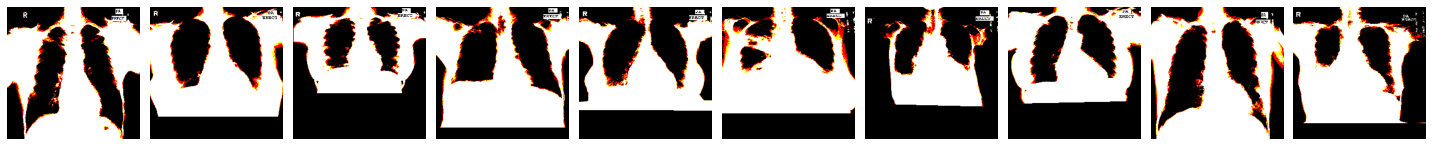

Labels:
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Class indices: {'normal': 0, 'tuberculosis': 1}


In [40]:
batchItem(train_batches)

In [44]:

# Creating Densenet121
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model
input_shape = 224, 224, 3
n_classes = 2
model = densenet(input_shape,n_classes)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 56, 56, 64)   0           conv2d_125[0][0]                 
__________________________________________________________________________________________________
batch_normalization_120 (BatchN (None, 56, 56, 64)   256         max_pooling2d_3[0][0]            
_______________________________________________________________________________________

Total params: 7,045,442
Trainable params: 6,963,970
Non-trainable params: 81,472
__________________________________________________________________________________________________


In [45]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=['accuracy'])

In [46]:
history = model.fit(x=train_batches, validation_data=valid_batches, epochs=15, verbose=1)

Epoch 1/15
10/10 [==============================] - 122s 12s/step - loss: 0.8145 - accuracy: 0.6020 - val_loss: 1.4715 - val_accuracy: 0.5000
Epoch 2/15
10/10 [==============================] - 110s 11s/step - loss: 0.6124 - accuracy: 0.6735 - val_loss: 1.3888 - val_accuracy: 0.5000
Epoch 3/15
10/10 [==============================] - 110s 11s/step - loss: 0.5555 - accuracy: 0.7143 - val_loss: 1.0640 - val_accuracy: 0.5000
Epoch 4/15
10/10 [==============================] - 111s 11s/step - loss: 0.4373 - accuracy: 0.7959 - val_loss: 0.7801 - val_accuracy: 0.5000
Epoch 5/15
10/10 [==============================] - 111s 11s/step - loss: 0.4044 - accuracy: 0.8367 - val_loss: 0.6876 - val_accuracy: 0.4500
Epoch 6/15
10/10 [==============================] - 108s 11s/step - loss: 0.2207 - accuracy: 0.9490 - val_loss: 0.6772 - val_accuracy: 0.5500
Epoch 7/15
10/10 [==============================] - 108s 11s/step - loss: 0.1843 - accuracy: 0.9388 - val_loss: 0.7709 - val_accuracy: 0.5000
Epoch 

In [47]:
# this functions plots accuracy vs val_accuracy over the 15 epochs
def plot_acc_vs_val_acc(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracies')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.show()

# this functions plots loss vs val_loss over the 15 epochs
def plot_loss_vs_val_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.show()

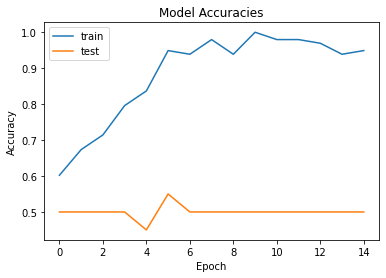

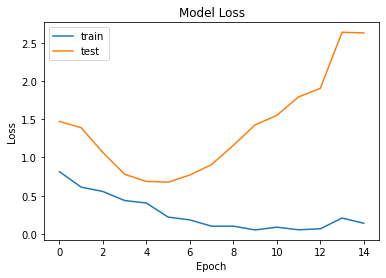

In [48]:
plot_acc_vs_val_acc(history)
plot_loss_vs_val_loss(history)